#CHAT-BOT

#Описание бота: 
В боте несколько интентов:

1.  Болталка с использованием 500000 ответов с mail.ru
2.  Генерация рецептов с дообученной  GPT
3.  Время
4.  На "спасибо" отвечает "Всегда пожалуйста!"
5.  Перевод на английский или при задании английского предложения или по ключу "переведи"
6.  Погода в городе 

key_time = ['время','час']
key_rec = ['рецепт', 'ингредиент', 'готовить']
key_ciao = ['спасибо']
key_weather = ['погода']
key_tr = ['перевод', 'переведи']

Классификация интентов реализована с помощью алгоритма CatBoost и в ряде случаев по ключевым словам, как например: со временем, погодой, переводом, и запросом рецепта..., а также  и "спасибо".

GPT2 дообучена на рецептах с kaggle

В болталке используется FastText и ближайшее векторное расстояние

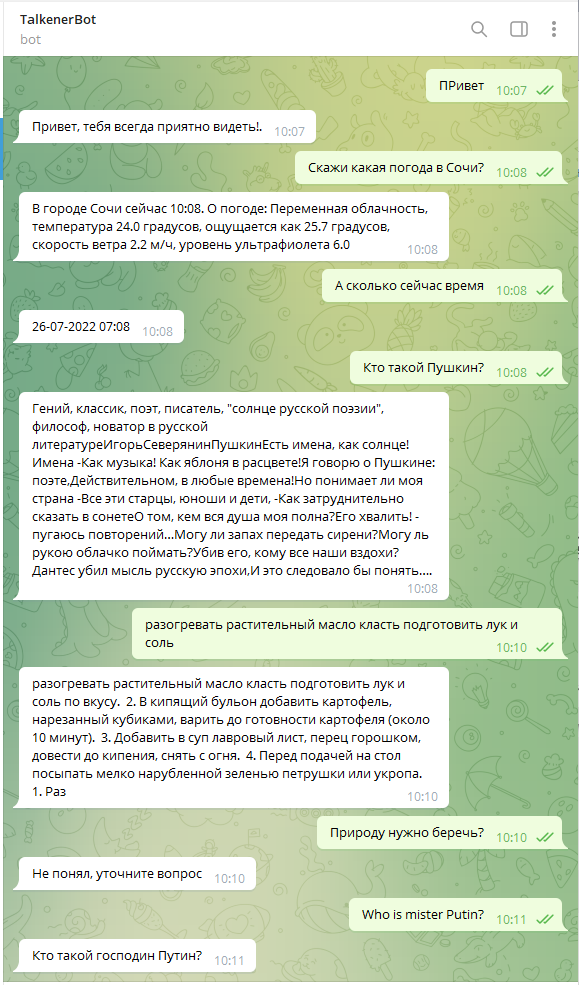

In [ ]:
from IPython.display import Image
Image('bot.png')

In [ ]:
!pip install python-telegram-bot --upgrade #restart needed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pymorphy2 stop_words annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from telegram import Update
from telegram.ext  import Updater, CommandHandler, MessageHandler, Filters, CallbackContext
import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
import annoy
from gensim.models import Word2Vec, FastText
import pickle
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import re
import logging
import datetime


Загрузка файлов данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Final/'

# Подготовка моделей и загрузка  данных

## Болталка

In [ ]:
morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)

In [ ]:
def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [ ]:
def preprocess_txt1(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i != ""]
    return spls

In [ ]:
with open(PATH + 'index_map.pkl', 'rb') as f:
  index_map = pickle.load(f)

In [ ]:
modelFT = FastText.load(PATH +"ft_model")

In [ ]:
modelFT.wv['двенашка']

array([ 2.9883865e-01, -2.7642512e+00,  4.2639930e-02, -1.2529160e-02,
       -8.4658277e-01,  1.0260692e+00,  1.8150332e+00, -7.7954537e-01,
        4.7490162e-01, -1.6236583e+00,  2.0812116e+00,  5.4272419e-01,
       -1.6641332e-01, -6.4201874e-01, -3.6265504e-01,  7.7537429e-01,
       -1.2964486e+00, -1.7865816e+00,  9.5354754e-01,  7.1971399e-01,
        1.0896443e+00,  1.1166829e+00, -5.6109625e-01,  1.2395247e+00,
        6.0932946e-01, -1.5272094e+00, -2.7702017e+00,  6.0276717e-01,
        1.2488464e+00, -3.0578065e-01,  2.7763116e-01, -1.3269508e+00,
       -8.2281929e-01,  1.4198306e+00, -9.1171688e-01, -6.1185058e-02,
       -1.4179436e+00, -9.1221690e-01,  4.6243864e-01,  3.4605947e-01,
       -3.8826275e-01,  1.4822145e+00,  1.9586509e+00,  1.4780412e+00,
        6.2605637e-01,  1.7629425e-01, -5.2186316e-01,  1.8909240e+00,
        3.8551840e-01,  7.9472518e-01, -1.8695779e+00, -4.9343964e-01,
       -3.9695829e-01, -1.3109518e+00, -6.2632300e-02,  1.6321678e+00,
      

In [ ]:
ft_index = annoy.AnnoyIndex(100, 'angular')
ft_index.load(PATH+'speaker.ann') 

True

In [ ]:
ft_index.get_nns_by_vector(np.zeros(100), 2)

[2286, 8306]

In [ ]:
TEXT = "ни хрена не работает"

In [ ]:
# Проверим болталку
def get_response(question, index, model, index_map):
    question = preprocess_txt(question)
    vector = np.zeros(100)
    norm = 0
    for word in question:
        if word in model.wv:
            vector += model.wv[word]
            norm += 1
    if norm > 0:
        vector = vector / norm
    answers = index.get_nns_by_vector(vector, 3)
    return [index_map[i] for i in answers]

In [ ]:
get_response(TEXT, ft_index, modelFT, index_map)

['Развод чистой воды.. \n', 'У меня своя фирма.. \n', 'Отлично работает.. \n']

## GPT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.8 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
     |████████████████████████████████| 6.6 MB 39.2 MB/s 
     |████████████████████████████████| 596 kB 62.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoTokenizer
#sberbank-ai/rugpt3large_based_on_gpt2
#sberbank-ai/rugpt3medium_based_on_gpt2
#sberbank-ai/rugpt3small_based_on_gpt2

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")



Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM

#model_sber = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

In [ ]:
tokenizer_gpt = AutoTokenizer.from_pretrained(PATH+"gpt_chf")
model_gpt = AutoModelForCausalLM.from_pretrained(PATH+"model_gpt_chf")

In [ ]:
prefix = "картошка и мясо"

In [ ]:
tokens = tokenizer_gpt(prefix, return_tensors='pt')
#tokens = {k: v.to(model.device) for k, v in tokens.items()}

In [ ]:
size = tokens['input_ids'].shape[1]
output = model_gpt.generate( 
    **tokens, 
    #end_token=end_token_id,
    do_sample=False, 
    max_length=size+50, 
    repetition_penalty=5., 
    temperature=1,
    num_beams=2,
)

decoded = tokenizer_gpt.decode(output[0])
result = decoded[len(prefix):]
print(prefix + result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


картошка и мясо, нарезанное кубиками.  3. В кипящий бульон добавить картофельное пюре, варить до готовности картофеля (около 15 минут).  4. Готовый суп разлить по тарелкам, посыпать рубленой петрушкой.


In [ ]:
def gpt_generate(prefix):
  tokens = tokenizer_gpt(prefix, return_tensors='pt')
  size = tokens['input_ids'].shape[1]
  output = model_gpt.generate( 
      **tokens, 
      #end_token=end_token_id,
      do_sample=False, 
      max_length=size+75, 
      repetition_penalty=5., 
      temperature=2,
      num_beams=3,
  )

  decoded = tokenizer_gpt.decode(output[0])
  result = decoded[len(prefix):]
  return prefix + result

In [ ]:
gpt_generate('Чеснок и помидоры')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Чеснок и помидоры измельчите в блендере до состояния пюре.  2. В сотейнике разогрейте оливковое масло, добавьте мелко нарезанный лук-шалот и обжарьте на среднем огне 5 минут. Добавьте томатную пасту и готовьте еще 3–4 минуты. Затем добавьте очищенный и нарезанный небольшими кубиками картофель и варите 20 минут'

## CatBoost для классификации интентов

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2))

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 137 kB/s 


In [ ]:
from catboost import CatBoostClassifier
cat_new = CatBoostClassifier()


In [ ]:
vectorizer =  pickle.load(open(PATH + "vectorizer.pickle", "rb"))


In [ ]:
with open(PATH+'cat_new.pkl', 'rb') as f:
  cat_new = pickle.load(f)

In [ ]:
input_txt = preprocess_txt('разогревать растительный масло класть подготовить репчатый лук морковь')
vect = vectorizer.transform([" ".join(input_txt)])
prediction = cat_new.predict_proba(vect)
print(prediction)

[[0.2148411 0.7851589]]


In [ ]:
def embed_txt(txt, idfs, midf):
    n_ft = 0
    vector_ft = np.zeros(100)
    for word in txt:
        if word in modelFT.wv:
            vector_ft += modelFT.wv[word] * 1 # idfs.get(word, midf)
            n_ft += 1 # idfs.get(word, midf)
    return vector_ft / n_ft

## Прогноз погоды

In [ ]:
import requests 
import json

key = '44' # Токен https://www.weatherapi.com/

def get_weather(city):
    url = f'http://api.weatherapi.com/v1/current.json?key={key}&q={city}&lang=ru'
    requests.get(url)
    response = requests.get(url)
    json_data = json.loads(response.text)

    city = json_data['location']['name']
    time = json_data['location']['localtime'].split(' ')[1]
    temp = json_data['current']['temp_c']
    temp_fl = json_data['current']['feelslike_c']
    condition = json_data['current']['condition']['text']
    wind = json_data['current']['wind_mph']
    uv = json_data['current']['uv']

    msg = f'В городе {city} сейчас {time}. О погоде: {condition}, температура {temp} градусов, ощущается как {temp_fl} градусов, скорость ветра {wind} м/ч, уровень ультрафиолета {uv}'

    return msg

In [ ]:
!python -m spacy download ru_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 5.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [ ]:
# Определение города
import spacy

nlp = spacy.load("ru_core_news_sm")
def location_recognition(text): 
    locs = []
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == 'LOC':
            locs.append(ent.text)
    locs = [morpher.parse(i.lower())[0].normal_form for i in locs]
    return locs

In [ ]:
# Погода в заданном городе
def forecast(text):
    city = location_recognition(text)
    try:
        forecast = get_weather(city)
    except:
        forecast = 'Не понимаю тебя'
    
    return forecast

In [ ]:
forecast('Какая погода в Пекине')

'В городе Пекин сейчас 14:52. О погоде: Солнечно, температура 30.0 градусов, ощущается как 30.3 градусов, скорость ветра 6.9 м/ч, уровень ультрафиолета 8.0'

## Перевод

In [ ]:
! pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 4.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=dc0001ac7a3ce1bc9e6b25e5010b5103e88d7d177c65d01d5b671c630dea859a
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [ ]:
# Загрузка модели

from transformers import FSMTForConditionalGeneration, FSMTTokenizer

model_name = "facebook/wmt19-en-ru"
tokenizer_tr = FSMTTokenizer.from_pretrained(model_name)
model_tr = FSMTForConditionalGeneration.from_pretrained(model_name)

Downloading:   0%|          | 0.00/624k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/308k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/827 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

In [ ]:
# Функция перевода

def en_ru_translation(text):
    input_ids = tokenizer_tr.encode(text, return_tensors="pt")
    outputs = model_tr.generate(input_ids)
    decoded = tokenizer_tr.decode(outputs[0], skip_special_tokens=True)
    
    return decoded

In [ ]:
en_ru_translation('White and black')

'Белое и черное'

In [ ]:
def is_english(text):
    return bool(re.search(r'[a-zA-Z]', text))

In [ ]:
re.sub(r'[а-яА-Я]', '', 'White and папа black', count=0)

'White and  black'

# Проверки

In [ ]:
key_time = ['время','час']
key_rec = ['рецепт', 'ингредиент', 'готовить']
key_ciao = ['спасибо']
key_weather = ['погода']
key_tr = ['перевод', 'переведи']
def check_in_list(text, key_list):
    for w in text:
      if w in key_list:
        flag = True
        break
      else:
        flag = False
    return flag

In [ ]:
print(preprocess_txt1('сколько времени'))

['сколько', 'время']


In [ ]:
print(preprocess_txt1('Какая погода в Москве?'))

['какой', 'погода', 'в', 'москва']


In [ ]:
check_in_list(preprocess_txt1('Какая сейчас  погода в Пекине?'), key_weather)

True

In [ ]:
check_in_list(['сколько', 'время'], key_time)

True

In [ ]:
# тестирую финальную функцию
def process(text):
    input_txt = preprocess_txt(text)
    input_txt1 = preprocess_txt1(text)
    print(input_txt1) #без стоп-слов
    print([" ".join(input_txt)])
    vect = vectorizer.transform([" ".join(input_txt)])
    prediction = cat_new.predict(vect)
    print(prediction)

    if check_in_list(input_txt1, key_tr): 
      try:
        print('TR')    
        print(en_ru_translation(re.sub(r'[а-яА-Я]', '', text , count=0)))
        return
      except Exception as e:
        print('Что-то пошло не так')
        return

    # Перевод с английского
    if is_english(text) == True:
        print('TR2')
        print(en_ru_translation(text))
        return

    if check_in_list(input_txt1, key_time): 
        print('DT')
        now = datetime.datetime.now()       
        print(now.strftime("%d-%m-%Y %H:%M"))
        return
    
    if check_in_list(input_txt1, key_ciao): 
        print('Пожалуйста!')
        return
    if check_in_list(input_txt1, key_weather): 
        print('W')
        print(forecast(' '.join(input_txt1)))
        return

    if check_in_list(input_txt1, key_rec): 
        print('REC')
        print(gpt_generate(text))
        return
    pred = cat_new.predict_proba(vect)
    print(pred)
    if prediction == 0:
        vect_ft = embed_txt(input_txt, {}, 1)
        ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
        if distances[0] > 0.45:
          print(distances[0])
          print("Моя твоя не понимать")
          return
        print(index_map[ft_index_val[0]])
        return
    
    
    # if prediction[0] == 1:
    #     gpt_generate(update.message.text)

    print(gpt_generate(text))

In [ ]:
process('разогревать растительный масло класть подготовить репчатый лук морковь')

['разогревать', 'растительный', 'масло', 'класть', 'подготовить', 'репчатый', 'лук', 'морковь']
['разогревать растительный масло класть подготовить репчатый лук морковь']
[1.]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[[0.2148411 0.7851589]]
разогревать растительный масло класть подготовить репчатый лук морковь и обжаривать до золотистого цвета.  2. Влить в сковороду бульон, добавить нарезанный кубиками картофель и тушить на медленном огне 5 минут.  3. Добавить томатную пасту, соль и перец по вкусу. Тушить еще 10 минут.  4. Готовый суп посыпать рубленой петрушкой.  1


In [ ]:
process('который час')

['который', 'час']
['час']
[0.]
DT
26-07-2022 06:54


In [ ]:
process('машина не едет что делать')

['машина', 'не', 'ехать', 'что', 'делать']
['машина ехать делать']
[0.]
[[0.99211224 0.00788776]]
Ну и флаг ему в руки.. . Сирены то нет... :ПДД 3.1 Для получения преимущества перед другими участниками движения водители таких транспортных средств должны включить проблесковый маячок синего цвета и специальный звуковой сигнал.Там же: Водители транспортных средств с включенным проблесковым маячком синего цвета, выполняя неотложное служебное задание, могут отступать от требований разделов 6 (кроме сигналов регулировщика) и 8 - 18 настоящих Правил, приложений 1 и 2 к настоящим Правилам при условии обеспечения безопасности движения. Вот пусть через сплошную и лезут.... 



In [ ]:
process('спасибо')

['спасибо']
['']
[0.]
Рад был помочь!


In [ ]:
process('Какая погода в Саратове?')

['какой', 'погода', 'в', 'саратов']
['погода саратов']
[0.]
W
Не понимаю тебя


In [ ]:
process('рецепт курника')

['рецепт', 'курник']
['рецепт курник']


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[0.]
REC
рецепт курника готов, приятного аппетита!  1. Разогрейте духовку до 200 градусов. В сотейнике растопите сливочное масло и обжарьте мелко нарезанный лук в течение 3-х минут. Добавьте измельченный чеснок и жарьте еще 2 минуты. Затем добавьте томатную пасту и тушите на медленном огне 5-7 минут.  2


In [ ]:
process('Переведи up, down')

['перевести', 'up', 'down']
['перевести up down']
[0.]
TR2
Переведи вверх, вниз


In [ ]:
process('Good bye my sun')

['good', 'bye', 'my', 'sun']
['good bye my sun']
[0.]
TR2
Прощай, мое солнце


#Подключение бота в телеграм

In [ ]:
BOT_API = '5X4U'
updater = Updater(BOT_API, use_context=True)  # Токен API к Telegram
dispatcher = updater.dispatcher

In [ ]:
def startCommand(update: Update, context: CallbackContext):
    update.message.reply_text('Нихао! Я могу перевести не сложный текст с \
     английского, сообщить погоду в разных городах, сказать, который час, придумать рецепт или просто поболтать')

def textMessage(update: Update, context: CallbackContext):
    input_txt = preprocess_txt(update.message.text)
    input_txt1 = preprocess_txt1(update.message.text) #без стоп-слов
    vect = vectorizer.transform([" ".join(input_txt)])
    prediction = cat_new.predict(vect)
    print(prediction)

    
    if check_in_list(input_txt1, key_tr): 
      try:
        print('TR')    
        update.message.reply_text(en_ru_translation(re.sub(r'[а-яА-Я]', '', update.message.text , count=0)))
        return
      except Exception as e:
        update.message.reply_text('Что-то пошло не так')
        return

    # Перевод с английского
    if is_english(update.message.text) == True:
        print('TR2')
        update.message.reply_text(en_ru_translation(update.message.text))
        return
    
    if check_in_list(input_txt1, key_ciao): 
        update.message.reply_text('Рад был помочь!')
        return
    
    if check_in_list(input_txt1, key_time): 
      
        now = datetime.datetime.now()       
        update.message.reply_text(now.strftime("%d-%m-%Y %H:%M"))
        return

    if check_in_list(input_txt1, key_weather): 
        print('W')
        update.message.reply_text(forecast(' '.join(input_txt1)))
        return

    if check_in_list(input_txt1, key_rec): 
        print('REC')
        update.message.reply_text(gpt_generate(update.message.text))
        return

    if prediction == 0:
        vect_ft = embed_txt(input_txt, {}, 1)
        ft_index_val, distances = ft_index.get_nns_by_vector(vect_ft, 1, include_distances=True)
        if distances[0] > 0.45:
          print(distances[0])
          update.message.reply_text("Не понял, уточните вопрос")
          return
        print('CH')  
        update.message.reply_text(index_map[ft_index_val[0]])
        return
    print('GPT')
    update.message.reply_text(gpt_generate(update.message.text))
    

In [ ]:
# on different commands - answer in Telegram
dispatcher.add_handler(CommandHandler("start", startCommand))
dispatcher.add_handler(MessageHandler(Filters.text & ~Filters.command, textMessage))

# Start the Bot
updater.start_polling()
updater.idle()

[0.]
CH
[0.]
W
[0.]
TR2


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[0.]
REC


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[0.]
REC
[0.]
CH
[0.]
CH
[0.]
W
[0.]
[0.]
CH
[0.]
CH


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[1.]
GPT
[0.]
0.4969326853752136
[0.]
TR2


In [ ]:
from IPython.display import Image
Image('bot.png')